<a href="https://colab.research.google.com/github/werd0n4/hand-gesture-classification/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

---


In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!ls
!cat proc/cpuinfo
!cat proc/meminfo

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import regularizers

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import os
import cv2
import glob
import random
from matplotlib import pyplot as plt

# Constant parameters

---



In [6]:
# horiz_x = 1024  
# vert_y = 768
horiz_x = 800  
vert_y = 600
batch_size = 32
image_shape = (horiz_x, vert_y, 3)
#drive paths
#
imgs_train_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Train/'
imgs_test_path = '/content/drive/My Drive/Colab Notebooks/Rozszerzony_dataset/Test/'
#local paths windows
#
# imgs_train_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
# imgs_test_path = 'C:\\Users\\Werdon\\Google Drive\\Colab Notebooks\\Rozszerzony_dataset\\Train'
#local paths manjaro
#
# imgs_train_path = '/home/werdon4/Rozszerzony_dataset/Train'
# imgs_test_path = '/home/werdon4/Rozszerzony_dataset/Test'


In [7]:

class_names = {
    0: "1",
    1: "2",
    2: "3",
    3: "4",
    4: "5",
    5: "A",
    6: "B",
    7: "C",
    8: "D",
    9: "E",
    10: "F",
    11: "G",
    12: "H",
    13: "I",
    14: "K",
    15: "L",
    16: "M",
    17: "N",
    18: "O",
    19: "P",
    20: "R",
    21: "S",
    22: "T",
    23: "U",
    24: "W",
    25: "Y",
    26: "Z"
}


# Auxiliary functions

---


## Image resize

In [8]:

def resize(path):
    img_counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            resized_img = cv2.resize(img, (horiz_x, vert_y))
            cv2.imwrite(image_path, resized_img)
            img_counter += 1
    
    print('Images in set: ' + str(img_counter))


## Image size sanity check

In [9]:

def sanity_check(path):
    counter = 0

    for dirname in os.listdir(path): 
        for filename in os.listdir(os.path.join(path, dirname)):
            image_path = os.path.join(path, dirname, filename)
            img = cv2.imread(image_path)
            if img.shape != (horiz_x, vert_y, 3):
                counter += 1

    print('Sanity result: ' + str(counter))

In [10]:

# def show_img(index, X, Y):
#     # plt.imshow(X[index])
#     plt.imshow(cv2.cvtColor(X[index],cv2.COLOR_BGR2RGB).astype('float32'))
#     plt.show()
#     nmb = int(np.where(Y[index] == 1)[0])
#     print("On image: " + class_names[nmb])

def show_img(i):
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    img = cv2.normalize(cv2.imread(testlist[i]), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    # print(img)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('float32'))

    label = testlist[i].split('/')[7]
    label = label.split('_')[1]

    # print(trainlist[i])
    print("Gesture: " + str(label))

    return img

# show_img(100)


## Load dataset

In [11]:

def load_dataset():
    trainlist = glob.glob(f'{imgs_train_path}/*/*')
    testlist = glob.glob(f'{imgs_test_path}/*/*')
    X_train = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in trainlist] )
    X_test = np.array( [np.array(cv2.normalize(cv2.imread(fname), None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)) for fname in testlist] )

    # Y_train = np.array([np.zeros(27) for fname in trainlist])
    Y_train = np.array([0 for fname in trainlist])
    for i,fname in enumerate(trainlist):
        # print(fname)
        img_id = fname.split('/')[7]##7 if windows 4 if manjaro
        img_id = img_id.split('_')[0]
        # Y_train[i][img_id] = 1
        Y_train[i] = img_id


    # Y_test = np.array([np.zeros(27) for fname in testlist])
    Y_test = np.array([0 for fname in testlist])
    for i,fname in enumerate(testlist):
        img_id = fname.split('/')[7]
        img_id = img_id.split('_')[0]
        # Y_test[i][img_id] = 1
        Y_test[i] = img_id

    return X_train, Y_train, X_test, Y_test

# load_dataset()


## Create network model

In [12]:

# def create_model():
model = Sequential()
# kernel_initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# kernel_initializer=None 
initializer = initializers.GlorotUniform(seed=10)
regularizer = regularizers.l2(l2=0.01)
activ_func = 'relu'
# kernel_regularizer=None
# activity_regularizer=None

# CONVOLUTIONAL LAYER - 1
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    input_shape=(vert_y, horiz_x, 3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 1
model.add(Conv2D(
    filters=6, 
    kernel_size=(5,5), 
    input_shape=(vert_y, horiz_x, 3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 1
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 2
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))
# CONVOLUTIONAL LAYER - 2
model.add(Conv2D(
    filters=16, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 2
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 3
model.add(Conv2D(
    filters=32, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 3
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 4
model.add(Conv2D(
    filters=60, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 4
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

# CONVOLUTIONAL LAYER - 5
model.add(Conv2D(
    filters=120, 
    kernel_size=(3,3), 
    activation=activ_func,
    kernel_initializer=initializer,
    bias_initializer=initializer,
    kernel_regularizer=regularizer,
    bias_regularizer=regularizer
    # activity_regularizer=activity_regularizer
))

# POOLING LAYER - 5
model.add(MaxPool2D(
    pool_size=(2,2),
    strides=(2,2)
))

######## FLATTEN ########
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(64, activation='relu'))
model.add(Dense(27, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam', 
    # optimizer=SGD(lr=0.01),
    metrics=['accuracy']
)

    # return model


# Loading dataset

---


## Resize images and do sanity check

In [13]:
# Uncomment before first run on dataset 
resize(imgs_train_path)
sanity_check(imgs_train_path)
resize(imgs_test_path)
sanity_check(imgs_test_path)


Images in set: 1686
Sanity result: 1686
Images in set: 297
Sanity result: 297


In [14]:
# X_train, Y_train, X_test, Y_test = load_dataset()

In [15]:
# One hot encoding
# Y_cat_train = to_categorical(Y_train, 27)
# Y_cat_test = to_categorical(Y_test, 27)

## Data augumentation

## Initializing ImageDataGenerator class

In [16]:
image_gen = ImageDataGenerator(rotation_range=10, # rotate the image 20 degrees
                               width_shift_range=0.05, # Shift the pic width by a max of 5%
                               height_shift_range=0.05, # Shift the pic height by a max of 5%
                            #    rescale=1./255, # Rescale the image by normalzing it.
                               shear_range=0.05, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.05, # Zoom in by 10% max
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                                )
                              

## Augumentation sample result

In [17]:
#augumentation sample result

#original img
# nmb = random.randint(0, 296)
# my_hand = X_test[nmb]
# show_img(nmb, X_test, Y_cat_test)

# #generated img
# gen_img = image_gen.random_transform(my_hand)
# print("Generated image")
# plt.imshow(cv2.cvtColor(gen_img,cv2.COLOR_BGR2RGB).astype('float32'))
# plt.show()

# comparison = my_hand == gen_img
# equal_arrays = comparison.all()
# print("Images are equal?: " + str(equal_arrays))

## Initializing test and train image geneartors

In [18]:
train_image_gen = image_gen.flow_from_directory(imgs_train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 1686 images belonging to 27 classes.


In [19]:
test_image_gen = image_gen.flow_from_directory(imgs_test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='categorical',shuffle=True)

Found 297 images belonging to 27 classes.


In [20]:
#train_image_gen.class_indices

# Create and train model

---


In [21]:
# CNN = create_model()
# CNN.summary()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 596, 796, 6)       456       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 592, 792, 6)       906       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 296, 396, 6)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 294, 394, 16)      880       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 292, 392, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 146, 196, 16)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 144, 194, 32)      4

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
#Y_cat_train.shape

## Fit model

In [23]:
# CNN.fit(X_train, Y_cat_train, epochs=12, validation_data=(X_test, Y_cat_test), batch_size=batch_size, callbacks=[early_stop])

## Fit model with data augumentation

In [24]:
results = model.fit(train_image_gen, epochs=32, validation_data=test_image_gen, callbacks=[early_stop], verbose=2)

Epoch 1/32
53/53 - 209s - loss: 5.0708 - accuracy: 0.0474 - val_loss: 4.2440 - val_accuracy: 0.0774
Epoch 2/32
53/53 - 207s - loss: 4.0293 - accuracy: 0.0949 - val_loss: 3.7654 - val_accuracy: 0.1380
Epoch 3/32
53/53 - 204s - loss: 3.6935 - accuracy: 0.1530 - val_loss: 3.4868 - val_accuracy: 0.1785
Epoch 4/32
53/53 - 212s - loss: 3.4000 - accuracy: 0.1916 - val_loss: 3.3871 - val_accuracy: 0.1886
Epoch 5/32
53/53 - 206s - loss: 3.2397 - accuracy: 0.2094 - val_loss: 3.3300 - val_accuracy: 0.2020
Epoch 6/32
53/53 - 205s - loss: 3.1159 - accuracy: 0.2307 - val_loss: 3.2127 - val_accuracy: 0.2357
Epoch 7/32
53/53 - 205s - loss: 2.9629 - accuracy: 0.2515 - val_loss: 3.0295 - val_accuracy: 0.2525
Epoch 8/32
53/53 - 204s - loss: 2.7596 - accuracy: 0.2960 - val_loss: 2.9040 - val_accuracy: 0.3131
Epoch 9/32
53/53 - 203s - loss: 2.6420 - accuracy: 0.3446 - val_loss: 2.8121 - val_accuracy: 0.2828
Epoch 10/32
53/53 - 201s - loss: 2.4989 - accuracy: 0.3677 - val_loss: 2.7262 - val_accuracy: 0.2828

## Saving model to file

In [25]:
model_path = '/content/drive/My Drive/Colab Notebooks/Zapisane modele/hand_gesture_classifier.h5'

In [26]:
model.save(model_path)

# Results

---


In [27]:
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,5.070826,0.047450,4.244039,0.077441
1,4.029332,0.094899,3.765421,0.138047
2,3.693535,0.153025,3.486760,0.178451
3,3.400000,0.191578,3.387092,0.188552
4,3.239663,0.209371,3.330009,0.202020
5,3.115884,0.230724,3.212722,0.235690
6,2.962950,0.251483,3.029493,0.252525
7,2.759578,0.295967,2.904019,0.313131
8,2.641985,0.344603,2.812096,0.282828
9,2.498932,0.367734,2.726215,0.282828


## Single image prediction

In [28]:
# model = load_model(model_path)
# model = create_model()
# model.load_weights(model_path)

Gesture: F
[17]
CNN says: N
Gesture: D
[17]
CNN says: N
Gesture: I
[17]
CNN says: N
Gesture: K
[17]
CNN says: N
Gesture: L
[17]
CNN says: N
Gesture: E
[17]
CNN says: N
Gesture: L
[17]
CNN says: N
Gesture: 1
[17]
CNN says: N
Gesture: O
[17]
CNN says: N
Gesture: A
[17]
CNN says: N


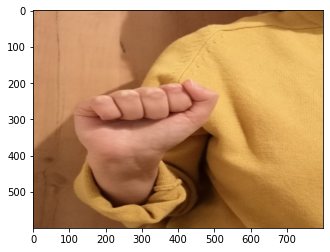

In [29]:
for i in range(10):
    nmb = random.randint(1, 200)
    my_hand = show_img(nmb)
    # print(my_hand)
    # show_img(nmb)
    my_hand = my_hand.reshape(1, vert_y, horiz_x, 3)
    # print(my_hand)
    # result = model.predict_classes(my_hand)
    result = np.argmax(model.predict(my_hand), axis=-1)
    # result = model.predict(my_hand)
    print(result)
    # result = (CNN.predict(my_hand) > 0.5).astype("int32")
    result = int(result)
    print('CNN says: ' + class_names[result])

Gesture: F
[[0.00319608 0.0543825  0.02489153 0.01156888 0.09454384 0.03450723
  0.02375303 0.00180731 0.00615454 0.01869593 0.05991928 0.00182924
  0.05929147 0.01025085 0.01850577 0.03054378 0.03030449 0.19067682
  0.06555247 0.00336471 0.00079052 0.00031346 0.0480257  0.08046785
  0.02902945 0.01675466 0.08087863]]
CNN says: N


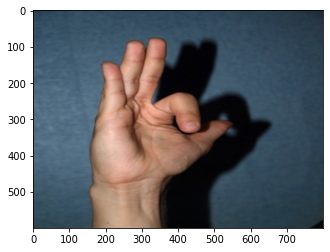

In [33]:
nmb = random.randint(1, 200)
my_hand = show_img(nmb)
my_hand = my_hand.reshape(1, vert_y, horiz_x, 3)
result = model.predict(my_hand)
print(result)
result = np.argmax(model.predict(my_hand), axis=-1)
result = int(result)
print('CNN says: ' + class_names[result])

In [31]:
my_hand = my_hand.reshape(1, vert_y, horiz_x, 3)
result = model.predict_classes(my_hand)
# result = (CNN.predict(my_hand) > 0.5).astype("int32")
result = int(result)
print('CNN says: ' + class_names[result])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
CNN says: N


## Predictions for individual classes

In [ ]:
# predictions = CNN.predict_classes(test_image_gen)

In [ ]:
# print(classification_report(Y_test,predictions))

In [ ]:
drive.flush_and_unmount()